# **Import Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [101]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# **Data Loading**

In [35]:
# Path to your dataset
dataset_path = Path("/content/drive/MyDrive/pores_dataset")
images_path = dataset_path / "pore_images"
masks_path = dataset_path / "masks"

## *Helper Function to Walk Through Directories*

In [ ]:
# Function to walk through directories
def walk_through_dir(base_path):
    for dirpath, dirnames, filenames in os.walk(base_path):
        print(f'Found {len(filenames)} images in {dirpath}')
        break

# Walk through images and masks directories
walk_through_dir(images_path)
walk_through_dir(masks_path)

## *Helper Class for Data Loading*

In [36]:
class PoreSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load image and mask
            image = Image.open(self.image_paths[idx]).convert("L")  # Grayscale
            mask = Image.open(self.mask_paths[idx]).convert("L")  # Grayscale
        except Exception as e:
            raise RuntimeError(f"Error loading image or mask: {e}")

        # Convert to tensors and normalize
        image = ToTensor()(image)  # Convert to Tensor and normalize to [0, 1]
        mask = ToTensor()(mask).float()  # Convert to Tensor and normalize to [0, 1]

        # Ensure binary masks
        mask = (mask > 0.5).float()  # Threshold to binary (0 or 1)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# **Load and Transform Data**

In [99]:
# Collect image and mask paths
image_paths = sorted(list(images_path.glob("*.tif")))
mask_paths = sorted(list(masks_path.glob("*.tif")))

# Split into train, validation, and test sets
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    train_image_paths, train_mask_paths, test_size=0.2, random_state=42
)

# Create datasets
train_dataset = PoreSegmentationDataset(train_image_paths, train_mask_paths)
val_dataset = PoreSegmentationDataset(val_image_paths, val_mask_paths)
test_dataset = PoreSegmentationDataset(test_image_paths, test_mask_paths)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [100]:
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Training dataset size: 307
Validation dataset size: 77
Test dataset size: 96


## *Visualizing a Random Sample*

In [ ]:
import torchvision.transforms as T
import random

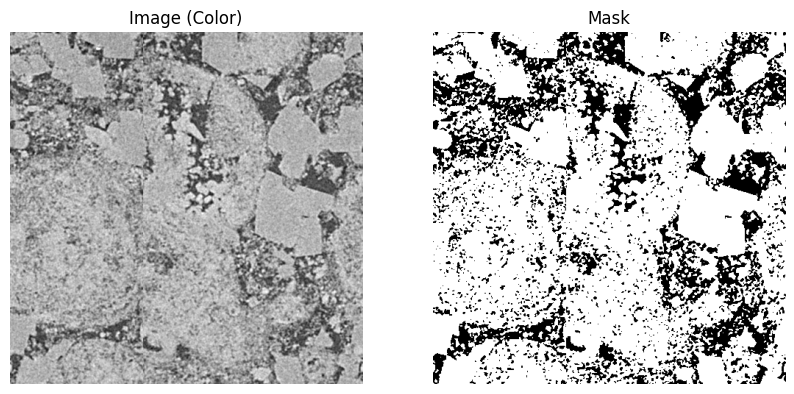

In [ ]:
# Function to display a random image and its mask
def display_random_image_with_mask(dataset):
    # Randomly select an index
    idx = random.randint(0, len(dataset) - 1)

    # Get the image and mask
    image, mask = dataset[idx]

    # If tensors, convert to PIL for visualization
    if isinstance(image, torch.Tensor):
        image = T.ToPILImage()(image)
    if isinstance(mask, torch.Tensor):
        mask = T.ToPILImage()(mask)

    # Display the image and mask
    plt.figure(figsize=(10, 5))

    # Display image in color
    plt.subplot(1, 2, 1)
    plt.imshow(image,cmap="gray")  # Displays image in GrayScale
    plt.title("Image (Color)")
    plt.axis("off")

    # Display mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.show()

# Display random image with mask from training dataset
display_random_image_with_mask(train_dataset)

# **Model (UNet Architecture)**

In [38]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.upconv1 = self.upconv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.upconv3 = self.upconv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

        self.upsample_to_input = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        dec1 = self.upconv1(enc4)
        dec2 = self.upconv2(dec1 + enc3)
        dec3 = self.upconv3(dec2 + enc2)

        final = self.final(dec3 + enc1)

        if final.shape[-2:] != x.shape[-2:]:
            final = self.upsample_to_input(final)

        return final

# **Loss Functions**

In [39]:
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = torch.nn.functional.interpolate(pred, size=(480, 480), mode='bilinear', align_corners=True)
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)

    intersection = (pred * target).sum(dim=1)
    pred_sum = pred.sum(dim=1)
    target_sum = target.sum(dim=1)

    dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)

    return 1 - dice.mean()

def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()  # Thresholding
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

# **Model Training**

In [62]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(1, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [63]:
history = {
    "train_loss": [],
    "val_loss": [],
    "iou_score": []
}

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss}")

    model.eval()
    val_loss = 0.0
    iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            val_loss += dice_loss(outputs, masks).item()
            iou += iou_score(outputs, masks).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_iou = iou / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    history["iou_score"].append(avg_iou)
    print(f"Validation Loss: {avg_val_loss}, IoU Score: {avg_iou}")

Epoch 1/100: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Epoch 1: Train Loss: 0.09154565930366516
Validation Loss: 0.12723312377929688, IoU Score: 0.7943719625473022


Epoch 2/100: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Epoch 2: Train Loss: 0.05691291689872742
Validation Loss: 0.07107830047607422, IoU Score: 0.8818437695503235


Epoch 3/100: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Epoch 3: Train Loss: 0.049504917860031125
Validation Loss: 0.05006494522094727, IoU Score: 0.9240531206130982


Epoch 4/100: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


Epoch 4: Train Loss: 0.04540117383003235
Validation Loss: 0.045250093936920165, IoU Score: 0.9306460499763489


Epoch 5/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 5: Train Loss: 0.04275975227355957
Validation Loss: 0.04246721267700195, IoU Score: 0.9324308872222901


Epoch 6/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 6: Train Loss: 0.040747106075286865
Validation Loss: 0.04079792499542236, IoU Score: 0.9325213551521301


Epoch 7/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 7: Train Loss: 0.03933959305286407
Validation Loss: 0.03961282968521118, IoU Score: 0.935355281829834


Epoch 8/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 8: Train Loss: 0.03842065334320068
Validation Loss: 0.03838659524917602, IoU Score: 0.9366809964179993


Epoch 9/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 9: Train Loss: 0.03746526539325714
Validation Loss: 0.03736389875411987, IoU Score: 0.937287437915802


Epoch 10/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 10: Train Loss: 0.036496907472610474
Validation Loss: 0.03660656213760376, IoU Score: 0.9377301692962646


Epoch 11/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 11: Train Loss: 0.035890957713127135
Validation Loss: 0.03619594573974609, IoU Score: 0.9378294944763184


Epoch 12/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 12: Train Loss: 0.03533807098865509
Validation Loss: 0.03536508083343506, IoU Score: 0.939305329322815


Epoch 13/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 13: Train Loss: 0.034595197439193724
Validation Loss: 0.03550232648849487, IoU Score: 0.9374835610389709


Epoch 14/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 14: Train Loss: 0.034280413389205934
Validation Loss: 0.0345190167427063, IoU Score: 0.9399695754051208


Epoch 15/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 15: Train Loss: 0.03380519151687622
Validation Loss: 0.03449108600616455, IoU Score: 0.9401546955108643


Epoch 16/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 16: Train Loss: 0.0331950306892395
Validation Loss: 0.03350937366485596, IoU Score: 0.9408124566078186


Epoch 17/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 17: Train Loss: 0.03270740509033203
Validation Loss: 0.03324770927429199, IoU Score: 0.9414127349853516


Epoch 18/100: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 18: Train Loss: 0.03241420984268188
Validation Loss: 0.03391472101211548, IoU Score: 0.9404696702957154


Epoch 19/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 19: Train Loss: 0.03210190832614899
Validation Loss: 0.034733152389526366, IoU Score: 0.9376737713813782


Epoch 20/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 20: Train Loss: 0.03163787126541138
Validation Loss: 0.03253018856048584, IoU Score: 0.9417464137077332


Epoch 21/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 21: Train Loss: 0.031127408146858215
Validation Loss: 0.03196084499359131, IoU Score: 0.9430927157402038


Epoch 22/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 22: Train Loss: 0.030823567509651185
Validation Loss: 0.03229858875274658, IoU Score: 0.9428899049758911


Epoch 23/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 23: Train Loss: 0.030419227480888367
Validation Loss: 0.031758344173431395, IoU Score: 0.9427737712860107


Epoch 24/100: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 24: Train Loss: 0.030260375142097472
Validation Loss: 0.031231164932250977, IoU Score: 0.9447489500045776


Epoch 25/100: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Epoch 25: Train Loss: 0.029707470536231996
Validation Loss: 0.0317933201789856, IoU Score: 0.9433406591415405


Epoch 26/100: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


Epoch 26: Train Loss: 0.029414990544319154
Validation Loss: 0.031126999855041505, IoU Score: 0.9435821652412415


Epoch 27/100: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 27: Train Loss: 0.028997978568077086
Validation Loss: 0.031890594959259035, IoU Score: 0.9422277331352233


Epoch 28/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 28: Train Loss: 0.028413888812065125
Validation Loss: 0.03384567499160766, IoU Score: 0.9387439966201783


Epoch 29/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 29: Train Loss: 0.028260469436645508
Validation Loss: 0.0295133113861084, IoU Score: 0.9470159888267518


Epoch 30/100: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 30: Train Loss: 0.027674108743667603
Validation Loss: 0.029547643661499024, IoU Score: 0.9465937495231629


Epoch 31/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 31: Train Loss: 0.02736727297306061
Validation Loss: 0.029650580883026124, IoU Score: 0.9465793967247009


Epoch 32/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 32: Train Loss: 0.027179881930351257
Validation Loss: 0.030067873001098634, IoU Score: 0.9453248381614685


Epoch 33/100: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 33: Train Loss: 0.027174201607704163
Validation Loss: 0.031362080574035646, IoU Score: 0.9426134705543519


Epoch 34/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 34: Train Loss: 0.026465559005737306
Validation Loss: 0.028824734687805175, IoU Score: 0.9479074478149414


Epoch 35/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 35: Train Loss: 0.025721558928489686
Validation Loss: 0.028653764724731447, IoU Score: 0.9483837962150574


Epoch 36/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 36: Train Loss: 0.02531799376010895
Validation Loss: 0.029783010482788086, IoU Score: 0.9456185102462769


Epoch 37/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 37: Train Loss: 0.025069817900657654
Validation Loss: 0.028084421157836915, IoU Score: 0.949124562740326


Epoch 38/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 38: Train Loss: 0.02448042333126068
Validation Loss: 0.02824960947036743, IoU Score: 0.9487797141075134


Epoch 39/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 39: Train Loss: 0.023957186937332155
Validation Loss: 0.028199481964111327, IoU Score: 0.9487975120544434


Epoch 40/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 40: Train Loss: 0.02383067011833191
Validation Loss: 0.0275429368019104, IoU Score: 0.9500518441200256


Epoch 41/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 41: Train Loss: 0.023367393016815185
Validation Loss: 0.027141928672790527, IoU Score: 0.9507191061973572


Epoch 42/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 42: Train Loss: 0.02302409112453461
Validation Loss: 0.028466641902923584, IoU Score: 0.9479029417037964


Epoch 43/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 43: Train Loss: 0.022734946012496947
Validation Loss: 0.028040480613708497, IoU Score: 0.9483753919601441


Epoch 44/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 44: Train Loss: 0.022079837322235108
Validation Loss: 0.02760106325149536, IoU Score: 0.9493615746498107


Epoch 45/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 45: Train Loss: 0.02159508168697357
Validation Loss: 0.02815556526184082, IoU Score: 0.9481261730194092


Epoch 46/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 46: Train Loss: 0.0214508593082428
Validation Loss: 0.027705156803131105, IoU Score: 0.9490996122360229


Epoch 47/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 47: Train Loss: 0.021458709239959718
Validation Loss: 0.028598701953887938, IoU Score: 0.9471248507499694


Epoch 48/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 48: Train Loss: 0.021078673005104066
Validation Loss: 0.027531516551971436, IoU Score: 0.9490622997283935


Epoch 49/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 49: Train Loss: 0.02121666371822357
Validation Loss: 0.03053238391876221, IoU Score: 0.9430666565895081


Epoch 50/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 50: Train Loss: 0.0206191748380661
Validation Loss: 0.026309764385223387, IoU Score: 0.9516491770744324


Epoch 51/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 51: Train Loss: 0.020025140047073363
Validation Loss: 0.029384911060333252, IoU Score: 0.9452258706092834


Epoch 52/100: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


Epoch 52: Train Loss: 0.02090218961238861
Validation Loss: 0.03284318447113037, IoU Score: 0.9381580352783203


Epoch 53/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 53: Train Loss: 0.02011962831020355
Validation Loss: 0.026118254661560057, IoU Score: 0.951819097995758


Epoch 54/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 54: Train Loss: 0.019211572408676148
Validation Loss: 0.02800196409225464, IoU Score: 0.9480284690856934


Epoch 55/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 55: Train Loss: 0.01886861026287079
Validation Loss: 0.027621400356292725, IoU Score: 0.9484443664550781


Epoch 56/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 56: Train Loss: 0.018585148453712463
Validation Loss: 0.026463246345520018, IoU Score: 0.9509188413619996


Epoch 57/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 57: Train Loss: 0.018409472703933717
Validation Loss: 0.027884161472320555, IoU Score: 0.947823965549469


Epoch 58/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 58: Train Loss: 0.018285933136940002
Validation Loss: 0.028265345096588134, IoU Score: 0.947092843055725


Epoch 59/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 59: Train Loss: 0.018244072794914246
Validation Loss: 0.027573931217193603, IoU Score: 0.9488876342773438


Epoch 60/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 60: Train Loss: 0.017923510074615477
Validation Loss: 0.02828134298324585, IoU Score: 0.9473837494850159


Epoch 61/100: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


Epoch 61: Train Loss: 0.017276105284690858
Validation Loss: 0.026960217952728273, IoU Score: 0.9497812867164612


Epoch 62/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 62: Train Loss: 0.01748124659061432
Validation Loss: 0.0287713885307312, IoU Score: 0.9458110690116882


Epoch 63/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 63: Train Loss: 0.01750260591506958
Validation Loss: 0.027384650707244874, IoU Score: 0.9488916039466858


Epoch 64/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 64: Train Loss: 0.01711123585700989
Validation Loss: 0.028404498100280763, IoU Score: 0.9469897627830506


Epoch 65/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 65: Train Loss: 0.017498886585235594
Validation Loss: 0.026856207847595216, IoU Score: 0.9499118804931641


Epoch 66/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 66: Train Loss: 0.017129454016685485
Validation Loss: 0.030026614665985107, IoU Score: 0.9431454300880432


Epoch 67/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 67: Train Loss: 0.016926309466361998
Validation Loss: 0.02746758460998535, IoU Score: 0.9483656167984009


Epoch 68/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 68: Train Loss: 0.016667330265045167
Validation Loss: 0.026179397106170656, IoU Score: 0.9508102297782898


Epoch 69/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 69: Train Loss: 0.0159303218126297
Validation Loss: 0.02620072364807129, IoU Score: 0.9509688138961792


Epoch 70/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 70: Train Loss: 0.016471138596534728
Validation Loss: 0.028189074993133546, IoU Score: 0.9466762185096741


Epoch 71/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 71: Train Loss: 0.01632407009601593
Validation Loss: 0.027741682529449464, IoU Score: 0.947812843322754


Epoch 72/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 72: Train Loss: 0.016904616355895997
Validation Loss: 0.026537656784057617, IoU Score: 0.9499886631965637


Epoch 73/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 73: Train Loss: 0.01572357416152954
Validation Loss: 0.026351869106292725, IoU Score: 0.9503018617630005


Epoch 74/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 74: Train Loss: 0.015268117189407349
Validation Loss: 0.026737821102142335, IoU Score: 0.9496587514877319


Epoch 75/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 75: Train Loss: 0.015540754795074463
Validation Loss: 0.026229798793792725, IoU Score: 0.9505445003509522


Epoch 76/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 76: Train Loss: 0.015127694606781006
Validation Loss: 0.02618039846420288, IoU Score: 0.9506285786628723


Epoch 77/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 77: Train Loss: 0.014976319670677186
Validation Loss: 0.027271318435668945, IoU Score: 0.9483441591262818


Epoch 78/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 78: Train Loss: 0.014819571375846862
Validation Loss: 0.02648324966430664, IoU Score: 0.9501246690750123


Epoch 79/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 79: Train Loss: 0.015011337399482728
Validation Loss: 0.026200497150421144, IoU Score: 0.9505066394805908


Epoch 80/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 80: Train Loss: 0.014830967783927918
Validation Loss: 0.02694857120513916, IoU Score: 0.9491997361183167


Epoch 81/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 81: Train Loss: 0.014978158473968505
Validation Loss: 0.02739272117614746, IoU Score: 0.948310124874115


Epoch 82/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 82: Train Loss: 0.014747807383537292
Validation Loss: 0.026343631744384765, IoU Score: 0.9501662373542785


Epoch 83/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 83: Train Loss: 0.01462523639202118
Validation Loss: 0.02785496711730957, IoU Score: 0.9470842957496644


Epoch 84/100: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


Epoch 84: Train Loss: 0.014391887187957763
Validation Loss: 0.029319334030151366, IoU Score: 0.9446109771728516


Epoch 85/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 85: Train Loss: 0.01437581479549408
Validation Loss: 0.026405847072601317, IoU Score: 0.9500259637832642


Epoch 86/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 86: Train Loss: 0.014170286059379578
Validation Loss: 0.026703917980194093, IoU Score: 0.9495085000991821


Epoch 87/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 87: Train Loss: 0.013979390263557434
Validation Loss: 0.026623010635375977, IoU Score: 0.9495494961738586


Epoch 88/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 88: Train Loss: 0.013720211386680604
Validation Loss: 0.0262367844581604, IoU Score: 0.9503491997718811


Epoch 89/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 89: Train Loss: 0.013659244775772095
Validation Loss: 0.025995051860809325, IoU Score: 0.9507159233093262


Epoch 90/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 90: Train Loss: 0.013613647222518921
Validation Loss: 0.026479732990264893, IoU Score: 0.9498595833778382


Epoch 91/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 91: Train Loss: 0.01384827196598053
Validation Loss: 0.026667511463165282, IoU Score: 0.9493456006050109


Epoch 92/100: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


Epoch 92: Train Loss: 0.01367548406124115
Validation Loss: 0.03021479845046997, IoU Score: 0.9426199913024902


Epoch 93/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 93: Train Loss: 0.013522174954414368
Validation Loss: 0.02717313766479492, IoU Score: 0.9483703136444092


Epoch 94/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 94: Train Loss: 0.013703900575637817
Validation Loss: 0.02652684450149536, IoU Score: 0.9496459364891052


Epoch 95/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 95: Train Loss: 0.013493180274963379
Validation Loss: 0.026046669483184813, IoU Score: 0.9504940867424011


Epoch 96/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 96: Train Loss: 0.013309773802757264
Validation Loss: 0.02634209394454956, IoU Score: 0.9499522566795349


Epoch 97/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 97: Train Loss: 0.013064804673194885
Validation Loss: 0.026515555381774903, IoU Score: 0.9495824337005615


Epoch 98/100: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 98: Train Loss: 0.012907484173774719
Validation Loss: 0.026925277709960938, IoU Score: 0.9488065719604493


Epoch 99/100: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 99: Train Loss: 0.012808310985565185
Validation Loss: 0.02589306831359863, IoU Score: 0.9507488250732422


Epoch 100/100: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 100: Train Loss: 0.013091176748275757
Validation Loss: 0.026852571964263917, IoU Score: 0.9488001704216004


## *Save the Model & Training History*

In [65]:
# Define the model save path
model_save_dir = "/content/drive/MyDrive/pores_dataset/Trained Model"
os.makedirs(model_save_dir, exist_ok=True)

# Save the model
def save_model(model, model_save_dir):
    model_path = os.path.join(model_save_dir, "model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

# Call the function to save the model
save_model(model, model_save_dir)

Model saved at /content/drive/MyDrive/pores_dataset/Trained Model/model.pth


In [94]:
import pickle

# Save the training history (as a pickle file)
history_path = os.path.join(model_save_dir, "history.pkl")
with open(history_path, 'wb') as history_file:
    pickle.dump(history, history_file)
print(f"History saved at {history_path}")

History saved at /content/drive/MyDrive/pores_dataset/Trained Model/history.pkl


## *Load the Model & Training History*

In [ ]:
# Define the model instance
model = UNet(in_channels=1, out_channels=1)  # Example for input RGB images and binary segmentation output
model.load_state_dict(torch.load("/content/drive/MyDrive/pores_dataset/Trained Model/model.pth"))

# If using GPU, move the model to the correct device (e.g., CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Load the history
with open(os.path.join("/content/drive/MyDrive/pores_dataset/Trained Model", "history.pkl"), 'rb') as history_file:
    history = pickle.load(history_file)

print("Model and history loaded successfully!")

## *Visualize the Training History*

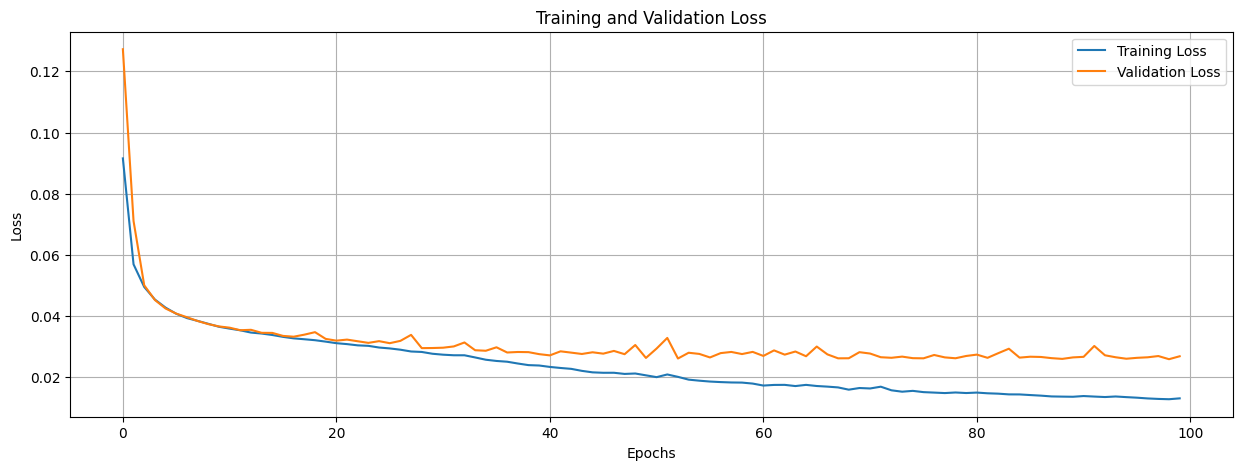

In [102]:
# Plot training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

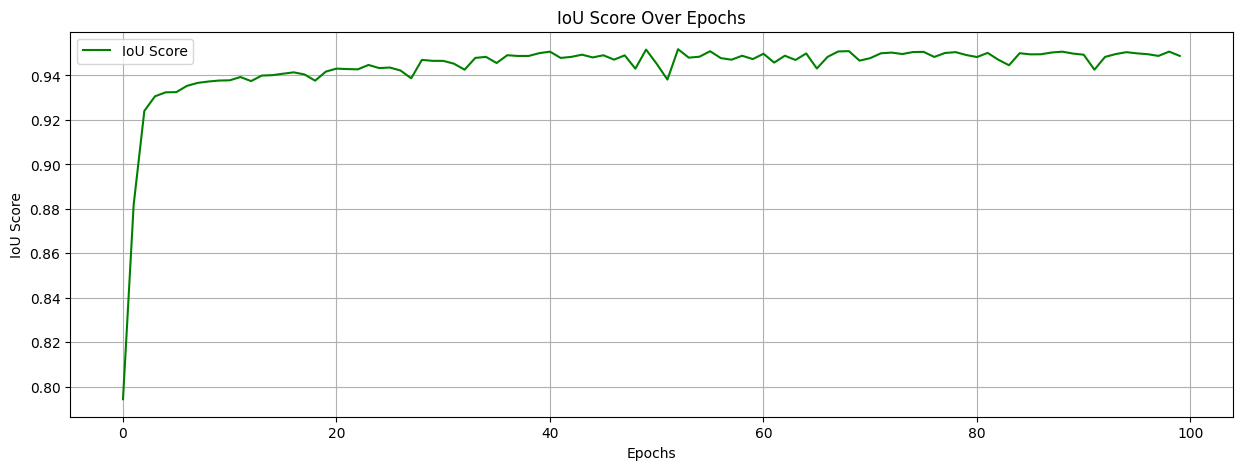

In [103]:
# Plot IoU score
plt.figure(figsize=(15, 5))
plt.plot(history["iou_score"], label="IoU Score", color="green")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.title("IoU Score Over Epochs")
plt.legend()
plt.grid()
plt.show()

# **Evaluate the Model**

## *Validation and Testing*

In [71]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [87]:
def dice_coefficient(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

def iou(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return intersection / (union + 1e-8)

# Evaluate model on test dataset
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    dice_scores, iou_scores, precisions, recalls, f1s = [], [], [], [], []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs.sigmoid() > threshold).float()

            for pred, mask in zip(preds, masks):
                dice_scores.append(dice_coefficient(pred.cpu().numpy(), mask.cpu().numpy()))
                iou_scores.append(iou(pred.cpu().numpy(), mask.cpu().numpy()))
                precisions.append(precision_score(mask.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))
                recalls.append(recall_score(mask.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))
                f1s.append(f1_score(mask.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))

    print(f"Dice Coefficient: {np.mean(dice_scores):.4f}")
    print(f"IoU: {np.mean(iou_scores):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f}")
    print(f"F1 Score: {np.mean(f1s):.4f}")

In [95]:
evaluate_model(model, test_loader)

Dice Coefficient: 0.9739
IoU: 0.9492
Precision: 0.9710
Recall: 0.9770
F1 Score: 0.9739


## *Error Analysis*

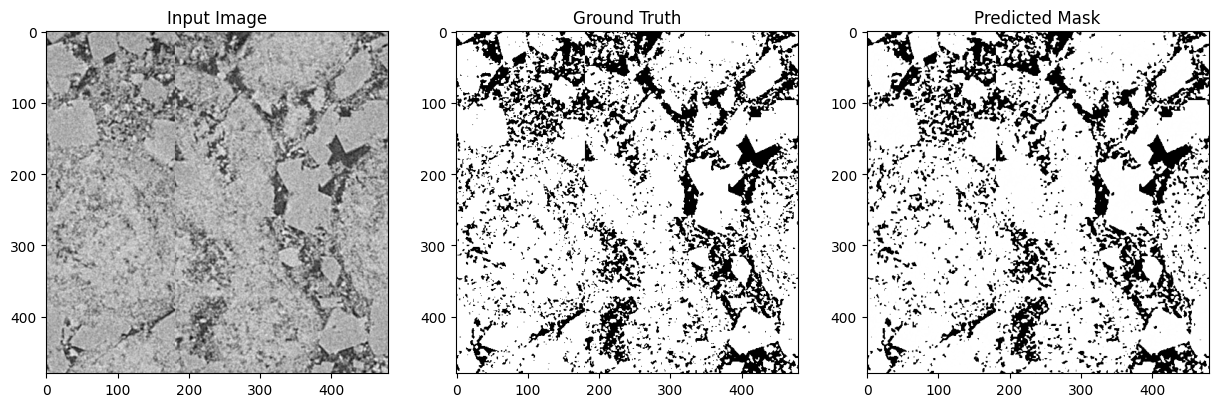

In [96]:
# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for images, masks in test_loader:
        # Move images and masks to the device
        images, masks = images.to(device), masks.to(device)

        # Get the model outputs
        outputs = model(images)
        outputs = torch.sigmoid(outputs).cpu().numpy()  # Apply sigmoid and move to CPU
        outputs = (outputs * 255).astype(np.uint8)  # Scale to [0, 255] for visualization

        images = images.cpu().numpy()
        masks = masks.cpu().numpy()

        # Visualize the input image, ground truth, and predicted mask
        fig, axes = plt.subplots(1, 3, figsize=(15, 6))

        # Input image (grayscale)
        axes[0].imshow(images[0, 0], cmap='gray')
        axes[0].set_title("Input Image")

        # Ground truth mask (binary, scaled to [0, 255] for visualization)
        axes[1].imshow(masks[0, 0], cmap='gray')
        axes[1].set_title("Ground Truth")

        # Predicted mask (scaled to [0, 255])
        axes[2].imshow(outputs[0, 0], cmap='gray')
        axes[2].set_title("Predicted Mask")

        # Display the visualization
        plt.show()

        break

# **Interpret Results**